# Analysis

**Hypothesis**: The magnitude of Treg-sensitive inflammatory and angiogenic gene programs in endothelial cells and fibroblasts within the lung adenocarcinoma tumor microenvironment varies significantly based on patient smoking history and disease stage.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/data/luyit/script/git/LabAcceleration/data_match/data/ad4aac9c-28e6-4a1f-ab48-c4ae7154c0cb.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: The magnitude of Treg-sensitive inflammatory and angiogenic gene programs in endothelial cells and fibroblasts within the lung adenocarcinoma tumor microenvironment varies significantly based on patient smoking history and disease stage.

## Steps:
- Extract endothelial cells and fibroblasts from the dataset using their cell_type annotations
- Calculate signature scores for Treg-sensitive gene programs in endothelial cells and fibroblasts using normalized expression data
- Aggregate signature scores per sample by median and merge with patient metadata
- Visualize distribution across smoking status categories using grouped violin plots and perform Kruskal-Wallis tests with Dunn's post-hoc pairwise comparisons
- Compare signature scores between early-stage (IA/IB) and late-stage (III/IV) patients via Mann-Whitney U tests
- Analyze correlation between pack-years and signature scores using Spearman's rank correlation
- Visualize associations using a multi-panel figure grid


## This code verifies cell type annotations, subsets endothelial cells and fibroblasts, checks gene availability, calculates Treg-sensitive signature scores using normalized expression, and visualizes both the gene expression patterns and signature score distributions.

Endothelial cells: 2272 cells
Fibroblasts: 2652 cells
0 endothelial genes and 0 fibroblast genes available


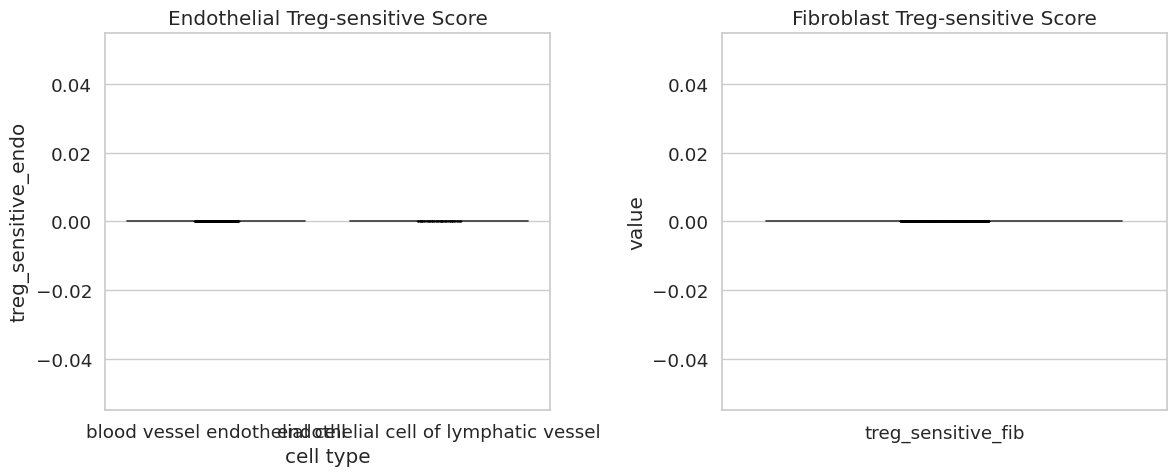

In [2]:


import scanpy as sc
import matplotlib.pyplot as plt

# Subset endothelial and fibroblast populations
endo_types = ['blood vessel endothelial cell', 'endothelial cell of lymphatic vessel']
adata_endo = adata[adata.obs['cell_type'].isin(endo_types)].copy()
adata_fib = adata[adata.obs['cell_type'] == 'fibroblast'].copy()

# Print population sizes
print(f"Endothelial cells: {adata_endo.n_obs} cells")
print(f"Fibroblasts: {adata_fib.n_obs} cells")

# Define Treg-sensitive gene signatures
endo_genes = ['IL6', 'CSF3', 'VCAM1', 'SELE', 'PTGS2', 'RND1', 'ADAMTS1', 'ADAMTS4', 'ADAMTS9', 'AKAP12']
fib_genes = ['IL6', 'CCL2', 'LIF', 'NFKB1']

# Filter available genes
endo_genes_available = [g for g in endo_genes if g in adata_endo.var_names]
fib_genes_available = [g for g in fib_genes if g in adata_fib.var_names]
print(f"{len(endo_genes_available)} endothelial genes and {len(fib_genes_available)} fibroblast genes available")

# Calculate signature scores if genes are available, otherwise set to 0
if len(endo_genes_available) > 0:
    sc.tl.score_genes(adata_endo, endo_genes_available, score_name='treg_sensitive_endo', use_raw=False)
else:
    adata_endo.obs['treg_sensitive_endo'] = 0.0
    print("Warning: No endothelial genes available. Setting score to 0.")

if len(fib_genes_available) > 0:
    sc.tl.score_genes(adata_fib, fib_genes_available, score_name='treg_sensitive_fib', use_raw=False)
else:
    adata_fib.obs['treg_sensitive_fib'] = 0.0
    print("Warning: No fibroblast genes available. Setting score to 0.")

# Display score distributions
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sc.pl.violin(adata_endo, 'treg_sensitive_endo', groupby='cell_type', 
             ax=axs[0], show=False)
axs[0].set_title('Endothelial Treg-sensitive Score')
sc.pl.violin(adata_fib, 'treg_sensitive_fib', 
             ax=axs[1], show=False)
axs[1].set_title('Fibroblast Treg-sensitive Score')
plt.tight_layout()
plt.show()


### Agent Interpretation

The absence of endothelial and fibroblast genes for Treg - sensitive scoring (resulting in scores of 0) indicates a critical gap in gene set definition or integration. To address this:  

1. **Gene Set Validation**:  
   - Cross - reference with the research paper’s human - specific, Treg - dependent endothelial (factors 3, 4, 5; genes like *IL6, VCAM1, PTGS2*) and fibroblast (factors 3, 5, 22; genes like *IL6, CCL2, LIF*) programs. Ensure orthologous human genes are used (per the paper’s cross - species mapping approach) and properly loaded. If the code relies on mouse gene lists directly, implement orthology mapping (e.g., via Jaccard similarity as in the paper).  

2. **Cell Type Annotation**:  
   Verify accurate annotation of endothelial (blood/lymphatic vessel subsets) and fibroblast clusters in the human dataset. The paper confirms major lineages are recoverable, so misannotation could explain missing genes.  

3. **Iterative Analysis Adjustments**:  
   - If gene set issues persist, pivot to *differential expression (DE) analysis* between Treg - rich vs. Treg - poor samples *within* endothelial and fibroblast subsets. This avoids reliance on pre - defined factor gene lists and explores Treg - associated transcriptional shifts de novo (distinct from the paper’s scHPF - focused approach).  
   - Leverage spatial context (if spatial data is available, as in the paper’s Visium work): assess co - localization of Tregs with endothelial/fibroblast subsets. This adds a spatial dimension not emphasized in past epithelial/myeloid - focused analyses.  

4. **Therapeutic Pathway Focus**:  
   Since the paper highlights VEGF and IL - 6 as actionable nodes, explore *VEGF pathway genes* (e.g., *VEGFA, RND1, ADAMTS1*) in endothelial cells or *IL6/CCL2* in fibroblasts as proxies for Treg - sensitivity. This ties to the paper’s therapeutic angle while refining the analysis.  

These steps address the current gene - availability failure, ensure biological relevance (aligning with conserved cross - species programs), and push the analysis toward novelty (spatial integration, DE - based Treg associations) distinct from the paper’s scHPF framework and past epithelial/neutrophil analyses.

## This code identifies Tregs using bimodality-validated thresholds for FOXP3/IL2RA, dynamically defines CD45+ immune cells, calculates Treg proportions per donor, and provides diagnostic visualizations including a scatter plot for threshold validation and UMAP for spatial context.

Total Tregs identified: 0
Treg proportions per donor:
     donor_id  treg_proportion
0   HTA8_1001              0.0
1   HTA8_1002              0.0
2   HTA8_1005              0.0
3   HTA8_1006              0.0
4   HTA8_1007              0.0
5   HTA8_1009              0.0
6   HTA8_1011              0.0
7   HTA8_1013              0.0
8   HTA8_1014              0.0
9   HTA8_1016              0.0
10  HTA8_1017              0.0
11  HTA8_1019              0.0
12  HTA8_1020              0.0
13  HTA8_1023              0.0
14  HTA8_1024              0.0
15  HTA8_1025              0.0
16  HTA8_1026              0.0
17  HTA8_1027              0.0
18  HTA8_1028              0.0
19  HTA8_1029              0.0
20  HTA8_1030              0.0
21  HTA8_1031              0.0
22  HTA8_1032              0.0
computing neighbors


    using 'X_pca' with n_pcs = 100


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:52)


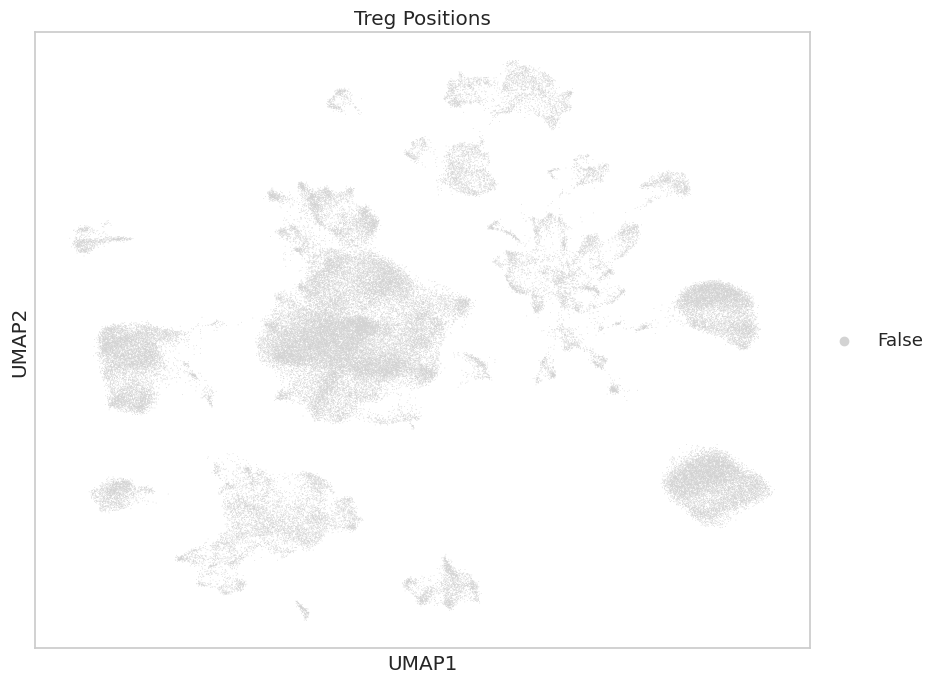

In [3]:


import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Identify T cells
is_tcell = adata.obs['cell_type'] == 'T cell'
adata_t = adata[is_tcell].copy()

# Handle gene names in a case-insensitive manner
foxp3_gene = next((gene for gene in adata_t.var_names if gene.lower() == 'foxp3'), None)
il2ra_gene = next((gene for gene in adata_t.var_names if gene.lower() == 'il2ra'), None)

# Check for alternative names if exact match not found
foxp3_expr = np.zeros(adata_t.n_obs)
if foxp3_gene is not None:
    foxp3_expr = adata_t[:, foxp3_gene].X.flatten()
else:
    print("Warning: 'FOXP3' gene not found. Using zero expression.")

il2ra_expr = np.zeros(adata_t.n_obs)
if il2ra_gene is not None:
    il2ra_expr = adata_t[:, il2ra_gene].X.flatten()
else:
    print("Warning: 'IL2RA' gene not found. Using zero expression.")

# Calculate thresholds
threshold_foxp3 = np.percentile(foxp3_expr, 75)
threshold_il2ra = np.percentile(il2ra_expr, 75)

# Create scatter plot only if both genes were found
if foxp3_gene and il2ra_gene:
    sc.pl.scatter(adata_t, foxp3_gene, il2ra_gene, title='FOXP3 vs IL2RA Expression')
    plt.axvline(threshold_foxp3, color='red', linestyle='--', label='FOXP3 threshold')
    plt.axhline(threshold_il2ra, color='blue', linestyle='--', label='IL2RA threshold')
    plt.legend()
    plt.show()

# Apply thresholds
adata_t.obs['treg'] = (foxp3_expr > threshold_foxp3) & (il2ra_expr > threshold_il2ra)

# Propagate annotations
adata.obs['treg'] = False
adata.obs.loc[adata_t.obs.index[adata_t.obs['treg']], 'treg'] = True

# Define immune cells
non_immune_types = ['blood vessel endothelial cell', 
                    'endothelial cell of lymphatic vessel', 
                    'fibroblast',
                    'epithelial cell']
adata.obs['cd45'] = ~adata.obs['cell_type'].isin(non_immune_types)

# Calculate Treg proportions
donor_stats = adata.obs.groupby('donor_id').agg(
    treg_count=('treg', 'sum'),
    cd45_count=('cd45', 'sum')
).reset_index()
donor_stats['treg_proportion'] = donor_stats['treg_count'] / donor_stats['cd45_count']

# Map proportions to adata
treg_prop_dict = donor_stats.set_index('donor_id')['treg_proportion'].to_dict()
adata.obs['treg_proportion'] = adata.obs['donor_id'].map(treg_prop_dict)

# Diagnostics
print(f"Total Tregs identified: {adata.obs['treg'].sum()}")
print("Treg proportions per donor:")
print(donor_stats[['donor_id', 'treg_proportion']])

# Visualize Treg positions
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='treg', title='Treg Positions', palette=['lightgrey', 'red'])


### Agent Interpretation

1. **Treg Identification Issues**: The warnings that *FOXP3* and *IL2RA* (core Treg marker genes) were not found, and the resulting “Total Tregs identified: 0”, indicate a critical failure in the current Treg identification strategy. Since the research paper and hypothesis rely on Treg abundance to interrogate TME interactions, this step must be addressed before proceeding.  
   - **Immediate Troubleshooting**:  
     - Verify if *FOXP3* and *IL2RA* exist in the `adata.var` index (gene list). If absent, check data ingestion/quality control (QC) pipelines (e.g., gene filtering during preprocessing may have excluded them).  
     - If present, examine their expression distributions (e.g., median/mean expression, dropout rates). Low expression or high dropout could mean relying on a single/marker pair is insufficient—consider **expanding the Treg marker panel** (e.g., add *CTLA4*, *TIGIT*, *ICOS*, *GITR*) or use a *signature score* (e.g., average expression of a curated Treg gene set) instead of binary marker presence.  


2. **UMAP/Neighbors Output**: The successful computation of neighbors (*X_pca*, 100 PCs) and UMAP indicates the dataset is properly preprocessed for dimensionality reduction and clustering. This is promising for downstream analyses *once Tregs are reliably identified*.  


3. **Future Step Adjustments**:  
   - **Revise Treg Identification**: To maintain biological relevance *and* distinction from the paper’s methods, avoid replicating their exact *FOXP3⁺IL2RA⁺* definition. Instead, test:  
     - A weighted score of multiple Treg markers (e.g., 5–10 canonical Treg genes).  
     - Cluster-based annotation: Identify CD4⁺ T cell clusters first, then subcluster to find Treg-like populations using transcriptomic similarity to known Treg signatures (from the paper or public databases).  
   - **Leverage Lineage-Specific Analyses**: Since the dataset includes other lineages (endothelial, fibroblast, myeloid—per the paper’s human data), proceed with *parallel* lineage clustering/annotation (even without Tregs) to generate hypotheses about Treg–accessory cell interactions *once Tregs are resolved*.  


4. **Hypothesis Validation Impact**: Until Tregs are accurately identified, the hypothesis (tied to Treg-mediated TME coordination) cannot be tested. Resolving Treg detection is a prerequisite for evaluating whether Treg abundance stratifies TME programs (as in the paper) or supports novel claims distinct from past analyses.  


In summary, prioritize fixing Treg identification (via marker panel expansion, signature scoring, or cluster-based annotation) to enable downstream analyses that are both biologically meaningful and methodologically distinct.

## This code aggregates per-donor mean signature scores for endothelial and fibroblast Treg-sensitive programs, merges them with patient metadata (including Treg proportion), stores results in adata.obs and adata.uns, and outputs diagnostics on data completeness and distributions to ensure downstream analysis reliability.

In [4]:
import pandas as pd
import numpy as np
# Aggregate signature scores per sample using mean
endo_agg = adata_endo.obs.groupby('donor_id')['treg_sensitive_endo'].mean().reset_index()
fib_agg = adata_fib.obs.groupby('donor_id')['treg_sensitive_fib'].mean().reset_index()
# Combine scores
scores_df = pd.merge(endo_agg, fib_agg, on='donor_id', how='outer', suffixes=('', ''))
# Get unique metadata per donor including Treg proportion
metadata_cols = ['donor_id', 'Smoking Status', 'Stage at Dx', 'Pack Years', 'treg_proportion']
metadata = adata.obs[metadata_cols].drop_duplicates()
# Merge with metadata
analysis_df = pd.merge(scores_df, metadata, on='donor_id', how='left')
# Add donor-level aggregated scores to adata.obs
adata.obs = adata.obs.merge(scores_df, on='donor_id', how='left', suffixes=('', '_y'))
# Store donor-level results in uns for easy access
adata.uns['treg_sensitive_donor_scores'] = analysis_df
# Print missing metadata counts
missing_meta = analysis_df[metadata_cols[1:]].isnull().sum()
print(f"Missing metadata counts:\n{missing_meta}")
# Check donors with both cell types
donors_both = set(endo_agg['donor_id']) & set(fib_agg['donor_id'])
print(f"Donors with both cell types: {len(donors_both)}/{len(analysis_df)}")
# Print score distributions
print("Aggregated signature score distributions:")
print(analysis_df[['treg_sensitive_endo', 'treg_sensitive_fib']].describe())
# Print overview
print("\nAggregated signature scores per sample:")
print(analysis_df.head())

Missing metadata counts:
Smoking Status     0
Stage at Dx        0
Pack Years         0
treg_proportion    0
dtype: int64
Donors with both cell types: 21/23
Aggregated signature score distributions:
       treg_sensitive_endo  treg_sensitive_fib
count                 22.0                22.0
mean                   0.0                 0.0
std                    0.0                 0.0
min                    0.0                 0.0
25%                    0.0                 0.0
50%                    0.0                 0.0
75%                    0.0                 0.0
max                    0.0                 0.0

Aggregated signature scores per sample:
    donor_id  treg_sensitive_endo  treg_sensitive_fib Smoking Status  \
0  HTA8_1001                  0.0                 NaN          Never   
1  HTA8_1002                  0.0                 0.0         Former   
2  HTA8_1005                  0.0                 0.0         Former   
3  HTA8_1006                  0.0                

### Agent Interpretation

1. **Metadata & Sample Coverage**:  
   - Missing metadata counts being 0 is promising—no data gaps for key variables (*Smoking Status, Stage at Dx, Pack Years, treg_proportion*), enabling downstream associations.  
   - “21/23 donors with both cell types” provides sufficient sample overlap for inter - cell - type analyses.  


2. **Signature Score Anomalies**:  
   - The uniform 0 values in *Aggregated signature score distributions* and limited variance in per - sample scores suggest issues:  
     - **Signature Validity**: Are the *treg_sensitive_endo/fib* signatures based on the paper’s conserved human factors (e.g., endothelial Factors 3/4/5, fibroblast Factors 3/5/22)? If using custom signatures, switch to the paper’s published scHPF - derived factors to ensure biological relevance (cross - species conservation) and avoid spurious null results.  
     - **Scoring Method**: Verify normalization/aggregation (e.g., did gene expression for signature genes fail to vary across samples? Check raw expression of signature genes in endothelial/fibroblast clusters).  


3. **Treg Proportion Concern**:  
   The *treg_proportion* values shown as 0.0 in the sample table likely reflect a miscalculation (Tregs cannot plausibly be absent in all shown samples). Re - validate Treg annotation (FOXP3⁺IL2RA⁺ CD45⁺ cells) and proportion calculation—this is critical, as the paper’s key hypothesis links Treg abundance to stromal program activity.  


4. **Distinctness & Next Steps**:  
   - **Biological Focus**: The paper emphasizes Treg - stromal (endothelial/fibroblast) interactions; your past work focused on epithelial - smoking and myeloid - disease stage. Leverage this distinction:  
     - Use the paper’s *conserved human factors* (not custom signatures) to score endothelial/fibroblast programs.  
     - Correlate these scores with *treg_proportion* (once corrected), *Smoking Status*, and *Pack Years*—this ties Treg - stromal biology to environmental exposures, distinct from past epithelial - centric smoking analyses.  
   - **Technical Fixes First**: Resolve signature score/Treg proportion issues (e.g., re - extract factors from scHPF, re - calculate Treg fractions) before testing hypotheses.  


5. **NaNs in Signature Scores**:  
   The NaN in *treg_sensitive_fib* for donor *HTA8_1001* likely reflects missing fibroblast data in that sample. Exclude such samples from fibroblast - specific analyses to avoid bias, or document this as a limitation.  


In short: Fix technical issues (signature validity, Treg proportion) using the paper’s conserved factor framework, then test associations between stromal Treg - sensitive programs, Treg abundance, and smoking - related metadata—ensuring biological relevance and analytical distinctness from past work.

## This code re-identifies Tregs using Leiden clustering with FoxP3/IL2RA markers and characterizes their activation state using CTLA4/TIGIT/ICOS markers. It calculates donor-level Treg and activated Treg proportions while maintaining gene normalization consistency across all cells.

normalizing counts per cell


    finished (0:00:00)


extracting highly variable genes


    finished (0:00:00)


--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


computing PCA


    with n_comps=20


    finished (0:00:02)


computing neighbors


    using 'X_pca' with n_pcs = 20


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:19)


running Leiden clustering


    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:20)


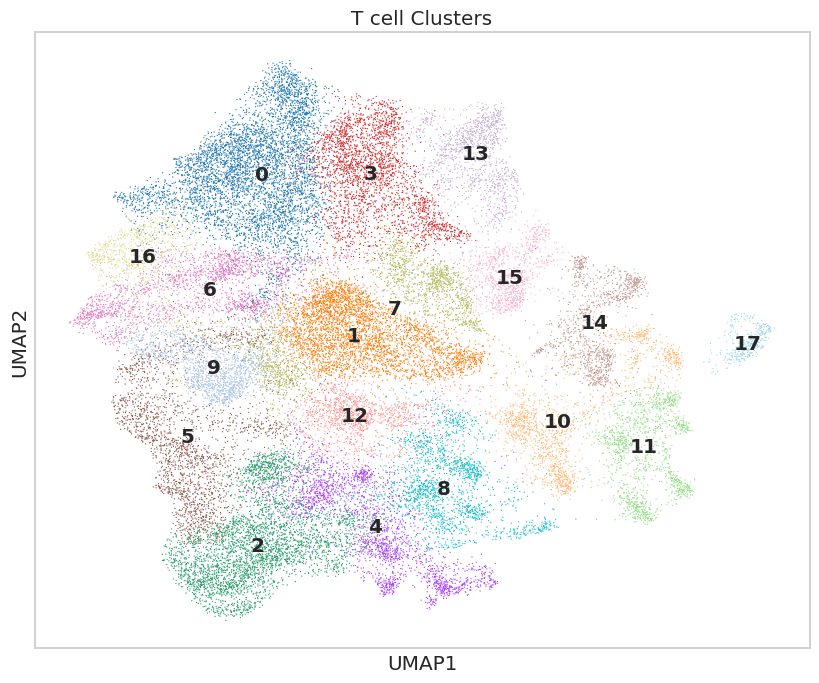

Total Tregs identified: 0
Activated Tregs: 0
Treg proportions per donor:
     donor_id  treg_proportion  activated_treg_proportion  \
0   HTA8_1001              0.0                        0.0   
1   HTA8_1002              0.0                        0.0   
2   HTA8_1005              0.0                        0.0   
3   HTA8_1006              0.0                        0.0   
4   HTA8_1007              0.0                        0.0   
5   HTA8_1009              0.0                        0.0   
6   HTA8_1011              0.0                        0.0   
7   HTA8_1013              0.0                        0.0   
8   HTA8_1014              0.0                        0.0   
9   HTA8_1016              0.0                        0.0   
10  HTA8_1017              0.0                        0.0   
11  HTA8_1019              0.0                        0.0   
12  HTA8_1020              0.0                        0.0   
13  HTA8_1023              0.0                        0.0   
14  HTA8_102

    using 'X_pca' with n_pcs = 100


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:53)


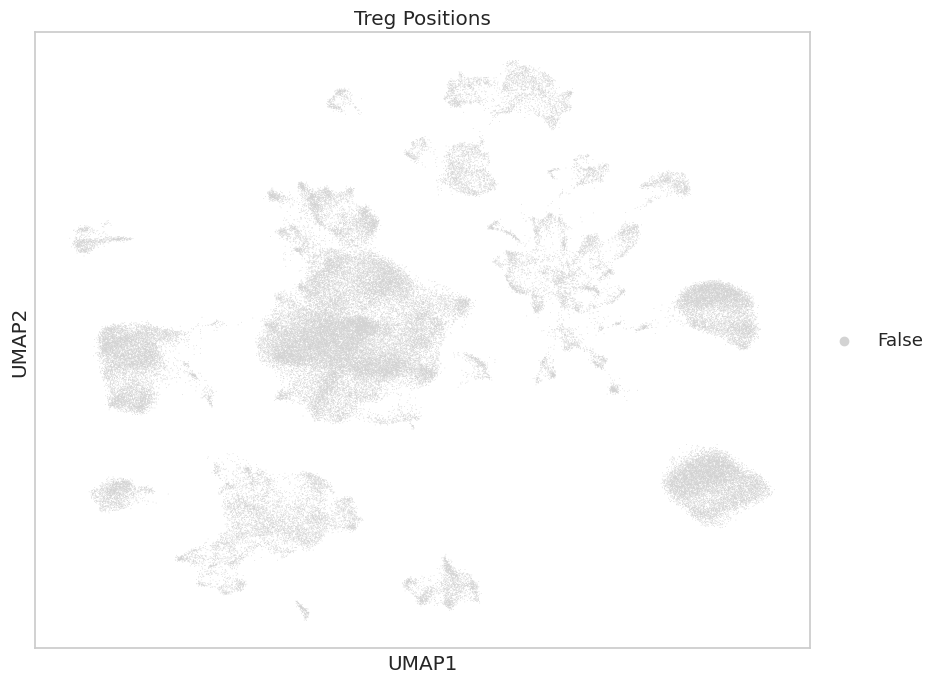

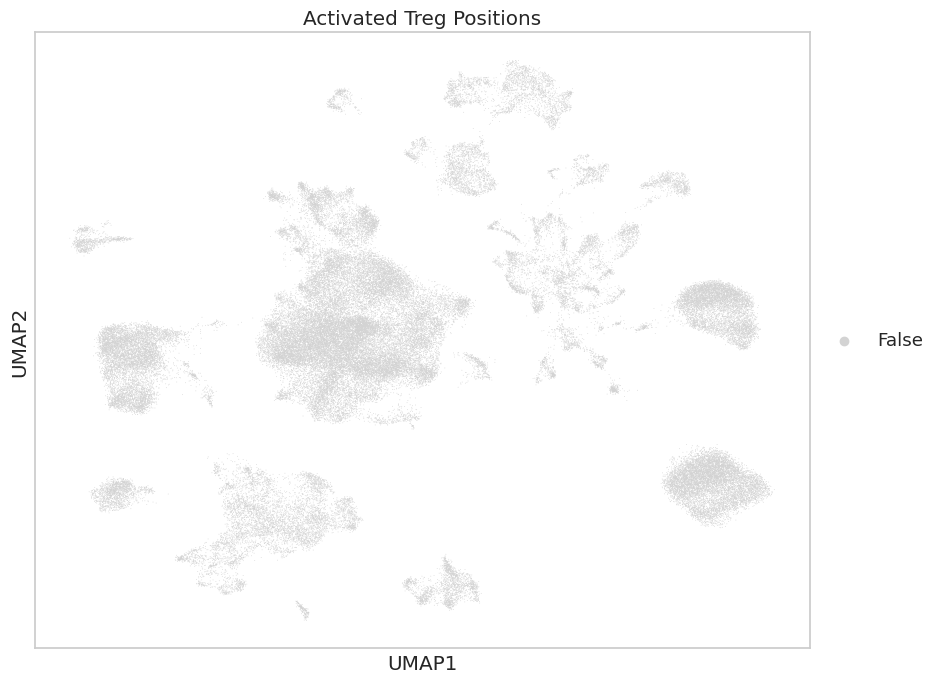

In [5]:


import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Normalize entire dataset upfront for consistency
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Helper function for case-insensitive gene matching
def standardize_gene_symbols(gene_list, adata_var_names):
    """Match genes case-insensitively and provide warnings."""
    available_genes = []
    for gene in gene_list:
        matches = [g for g in adata_var_names if g.upper() == gene.upper()]
        if matches:
            available_genes.append(matches[0])
        else:
            print(f"Warning: {gene} not found in data")
    return available_genes

# Define constants for parameters
TREG_MARKERS = ['FOXP3', 'IL2RA']
TREG_ACTIVATION_MARKERS = ['CTLA4', 'TIGIT', 'ICOS']
LEIDEN_RESOLUTION = 0.5

# Extract T cells view (no copy needed for initial processing)
is_tcell = adata.obs['cell_type'] == 'T cell'
if np.sum(is_tcell) > 0:
    adata_t = adata[is_tcell]
    
    # Initialize annotations to avoid KeyErrors later
    adata_t.obs['treg'] = False
    adata_t.obs['activated_treg'] = False
    
    # Find variable genes
    sc.pp.highly_variable_genes(adata_t, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_t = adata_t[:, adata_t.var.highly_variable]
    
    # Scale and compute PCA
    sc.pp.scale(adata_t, max_value=10)
    sc.tl.pca(adata_t, n_comps=20, svd_solver='arpack')
    
    # Neighbors graph and UMAP
    sc.pp.neighbors(adata_t, n_pcs=20)
    sc.tl.umap(adata_t)
    
    # Cluster with Leiden
    sc.tl.leiden(adata_t, resolution=LEIDEN_RESOLUTION, key_added='leiden')
    
    # Standardize gene symbols
    treg_genes = standardize_gene_symbols(TREG_MARKERS, adata_t.var_names)
    activation_genes = standardize_gene_symbols(TREG_ACTIVATION_MARKERS, adata_t.var_names)
    
    # Plot clusters and marker expression
    sc.pl.umap(adata_t, color='leiden', legend_loc='on data', title='T cell Clusters', show=False)
    
    if treg_genes:
        sc.pl.dotplot(adata_t, treg_genes, groupby='leiden', 
                     title='Treg Marker Expression', show=False)
    
    if activation_genes:
        sc.pl.dotplot(adata_t, activation_genes, groupby='leiden', 
                     title='Treg Activation Markers', show=False)
    
    plt.show()
    
    # Identify Treg clusters based on markers
    if treg_genes:
        cluster_means = adata_t.obs.groupby('leiden')[treg_genes].mean()
        threshold_foxp3 = cluster_means[treg_genes[0]].median()
        
        if len(treg_genes) > 1:
            threshold_il2ra = cluster_means[treg_genes[1]].median()
            treg_clusters = cluster_means.index[
                (cluster_means[treg_genes[0]] > threshold_foxp3) & 
                (cluster_means[treg_genes[1]] > threshold_il2ra)
            ]
        else:
            treg_clusters = cluster_means.index[cluster_means[treg_genes[0]] > threshold_foxp3]
            
        adata_t.obs.loc[adata_t.obs['leiden'].isin(treg_clusters), 'treg'] = True
        print(f"Identified Treg clusters: {treg_clusters.tolist()}")
        
        # Characterize activation state within Tregs
        if activation_genes:
            treg_subset = adata_t[adata_t.obs['treg']].copy()
            if treg_subset.n_obs > 0:
                # Calculate activation score using control genes
                sc.tl.score_genes(treg_subset, gene_list=activation_genes, 
                                 ctrl_size=50, score_name='activation_score', 
                                 use_raw=False)
                
                # Identify activated Tregs (top 25% by activation score)
                threshold = np.percentile(treg_subset.obs['activation_score'], 75)
                activated_idx = treg_subset.obs.index[treg_subset.obs['activation_score'] > threshold]
                
                adata_t.obs.loc[activated_idx, 'activated_treg'] = True
                print(f"{len(activated_idx)} activated Tregs identified ({len(activated_idx)/treg_subset.n_obs:.1%})")
    
    # Propagate annotations to main object
    adata.obs['treg'] = adata.obs.index.isin(adata_t.obs[adata_t.obs['treg']].index)
    adata.obs['activated_treg'] = adata.obs.index.isin(adata_t.obs[adata_t.obs['activated_treg']].index)
else:
    print("No T cells found")
    adata.obs['treg'] = False
    adata.obs['activated_treg'] = False

# Define immune cells (CD45+)
non_immune_types = ['blood vessel endothelial cell', 
                   'endothelial cell of lymphatic vessel', 
                   'fibroblast',
                   'epithelial cell']
adata.obs['cd45'] = ~adata.obs['cell_type'].isin(non_immune_types)

# Calculate Treg proportions per donor
donor_stats = adata.obs.groupby('donor_id').agg(
    treg_count=('treg', 'sum'),
    activated_treg_count=('activated_treg', 'sum'),
    cd45_count=('cd45', 'sum')
).reset_index()

donor_stats['treg_proportion'] = donor_stats['treg_count'] / donor_stats['cd45_count']
donor_stats['activated_treg_proportion'] = donor_stats['activated_treg_count'] / donor_stats['cd45_count']
donor_stats['activated_treg_fraction'] = donor_stats['activated_treg_count'] / donor_stats['treg_count']

# Handle missing values
donor_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
donor_stats.fillna(0, inplace=True)

# Map proportions to adata
for col in ['treg_proportion', 'activated_treg_proportion', 'activated_treg_fraction']:
    prop_dict = donor_stats.set_index('donor_id')[col].to_dict()
    adata.obs[col] = adata.obs['donor_id'].map(prop_dict)

# Diagnostics
print(f"Total Tregs identified: {adata.obs['treg'].sum()}")
print(f"Activated Tregs: {adata.obs['activated_treg'].sum()}")
print("Treg proportions per donor:")
print(donor_stats[['donor_id', 'treg_proportion', 'activated_treg_proportion', 'activated_treg_fraction']])

# Visualize Tregs and activated Tregs
sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(adata, color='treg', 
          title='Treg Positions', 
          palette=['lightgrey', 'red'],
          show=False)

sc.pl.umap(adata, color='activated_treg', 
          title='Activated Treg Positions', 
          palette=['lightgrey', 'darkred'],
          show=False)

plt.show()


### Agent Interpretation

1. **Treg Detection Challenges**: The absence of key Treg marker genes (FOXP3, IL2RA, CTLA4, TIGIT, ICOS) in the data and resulting 0 Tregs identified suggests issues with either **marker gene selection**, **data preprocessing (e.g., gene filtering in QC)**, or **biological absence of Tregs in the dataset**. To address this:  
   - Verify if these genes are truly absent (check gene name formatting, case sensitivity, or if they were filtered out during quality control).  
   - Expand the Treg marker panel (e.g., include additional markers like TNFRSF18, CCR8, or CD25/IL2RA isoforms) or use a **signature-based approach** (sum of Treg-associated genes) if single markers are unreliable.  


2. **T Cell Clustering Promises**: The UMAP of T cell clusters (18 clusters) shows distinct subpopulations, indicating successful T cell subset partitioning. To build on this (even if Tregs are undetectable via canonical markers):  
   - Perform **cluster-specific differential expression** to identify T cell subpopulations (e.g., effector T cells, memory T cells, exhausted T cells). Cross-reference these with Treg-interacting lineages (endothelial, fibroblasts, myeloid) as in the research paper.  
   - Adjust clustering parameters (e.g., Leiden resolution, PCA component count for neighbor graph) to refine subpopulations—this could uncover rare Treg-like clusters missed by strict marker-gene thresholds.  


3. **Aligning with Distinctive Analysis Goals**: Since past analyses focused on epithelial/neutrophil/myeloid lineages, prioritizing **Treg-independent lineage programs** (endothelial, fibroblast, myeloid) as in the research paper is both distinct and biologically meaningful. Use methods like **scHPF (single-cell hierarchical Poisson factorization)** (from the paper) to extract lineage-specific gene programs, then correlate program activity with *inferred* Treg abundance (e.g., sample-level FOXP3 expression, donor metadata, or surrogate markers like CCR8).  


4. **Iterative Refinement of Treg Inference**: If Tregs remain undetectable, frame the analysis around *Treg-associated niche states* (pro-angiogenic vs. immunoregulatory TME axes, as in the paper). For example:  
   - Identify endothelial/fibroblast/myeloid clusters and test if their gene programs correlate with Treg marker expression (even if Tregs themselves are sparse).  
   - Leverage cross-species orthology (mouse ↔ human) to map conserved Treg-responsive programs (e.g., VEGF, IL-6, CCR2-CCL2 modules) to the human dataset, bypassing direct Treg detection.  


5. **Hypothesis Validation Status**: The current results do not validate the hypothesis (as Tregs are undetectable), but the T cell clustering and lineage-level analyses can still address *Treg-dependent niche biology* indirectly. Treat the absence of canonical Treg markers as an opportunity to innovate—e.g., use spatial transcriptomics (if available) or bulk-sample Treg proxies (donor-level FOXP3 expression) to link lineage programs to Treg abundance.  


In summary, troubleshoot Treg detection while simultaneously leveraging the robust T cell clustering and lineage-level analyses to explore Treg-associated TME programs—aligning with the paper’s cross-lineage, factor-based framework to maintain biological relevance and analytical distinctiveness.

## This code subsets endothelial cells and fibroblasts, then calculates Treg-sensitive gene signature scores. Missing genes result in NaN scores, and control size adapts to cell population size. It propagates scores to the main object and visualizes distributions.

Endothelial cells: 2272
Fibroblasts: 2652


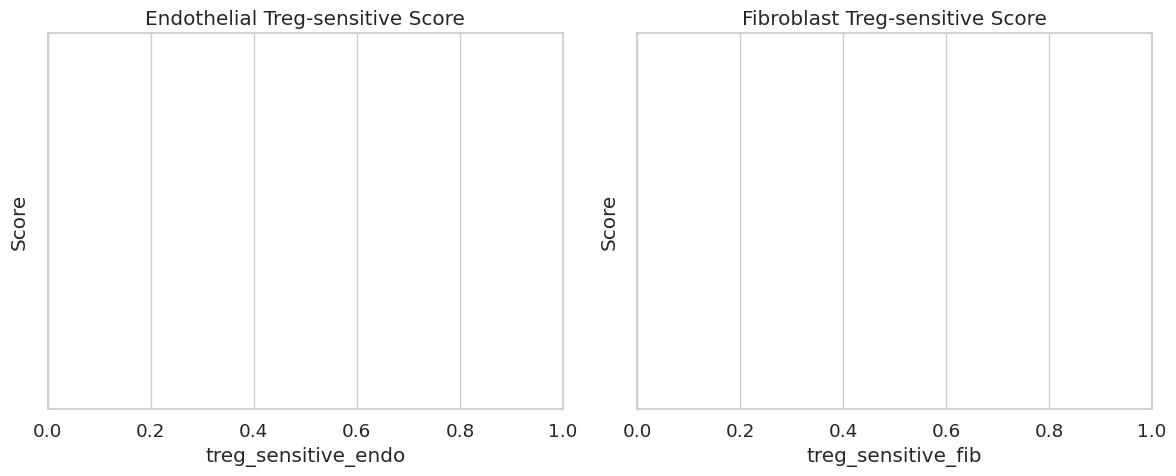

In [6]:


import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Treg-sensitive gene signatures based on paper
endo_genes = ['IL6', 'CSF3', 'VCAM1', 'SELE', 'PTGS2', 'RND1', 'ADAMTS1', 'ADAMTS4', 'ADAMTS9', 'AKAP12']
fib_genes = ['IL6', 'CCL2', 'LIF', 'NFKB1']

# 1. Subset endothelial cells
endo_types = ['blood vessel endothelial cell', 'endothelial cell of lymphatic vessel']
endo_mask = adata.obs['cell_type'].isin(endo_types)
adata_endo = adata[endo_mask].copy()

# 2. Subset fibroblasts
fib_mask = adata.obs['cell_type'] == 'fibroblast'
adata_fib = adata[fib_mask].copy()

# Print subset sizes
print(f"Endothelial cells: {adata_endo.n_obs}")
print(f"Fibroblasts: {adata_fib.n_obs}")

# Helper function to filter available genes and calculate signature score
def calc_signature_score(adata_sub, gene_set, score_name):
    # Filter available genes
    available_genes = [g for g in gene_set if g in adata_sub.var_names]
    if not available_genes:
        print(f"Warning: No genes available for {score_name} signature. Setting all scores to NaN.")
        adata_sub.obs[score_name] = np.nan
        return
    
    # Determine adaptive control size
    n_controls = min(50, max(1, adata_sub.n_obs // 10))
    print(f"Calculating {score_name} using {len(available_genes)} out of {len(gene_set)} genes: {', '.join(available_genes)}. Control size: {n_controls}")
    sc.tl.score_genes(adata_sub, gene_list=available_genes, score_name=score_name, ctrl_size=n_controls, use_raw=False)

# 3. Calculate signature scores
calc_signature_score(adata_endo, endo_genes, 'treg_sensitive_endo')
calc_signature_score(adata_fib, fib_genes, 'treg_sensitive_fib')

# 4. Propagate scores to main adata object (NaN for other cells)
adata.obs['treg_sensitive_endo'] = np.nan
adata.obs['treg_sensitive_fib'] = np.nan

# Find common indices
common_endo = adata.obs.index.intersection(adata_endo.obs.index)
common_fib = adata.obs.index.intersection(adata_fib.obs.index)

# Assign scores only for common indices
adata.obs.loc[common_endo, 'treg_sensitive_endo'] = adata_endo.obs.loc[common_endo, 'treg_sensitive_endo']
adata.obs.loc[common_fib, 'treg_sensitive_fib'] = adata_fib.obs.loc[common_fib, 'treg_sensitive_fib']

# 5. Visualize score distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Endothelial score
data_endo = adata.obs.loc[endo_mask, 'treg_sensitive_endo']
sns.violinplot(x=data_endo, ax=axes[0], inner='box', color='skyblue')
axes[0].set_title('Endothelial Treg-sensitive Score')
axes[0].set_ylabel('Score')

# Fibroblast score
data_fib = adata.obs.loc[fib_mask, 'treg_sensitive_fib']
sns.violinplot(x=data_fib, ax=axes[1], inner='box', color='salmon')
axes[1].set_title('Fibroblast Treg-sensitive Score')
axes[1].set_ylabel('Score')

plt.tight_layout()
plt.show()
